In [556]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import random
import scipy 
from scipy.spatial.distance import pdist , cdist

import matplotlib.pyplot as plt
 
from math import sin, cos, sqrt, atan2, radians
 
import pickle
import os 
import sys
import math


In [557]:
parent_dir = sys.path[0]
 

data_depot = pd.read_csv(os.path.join(parent_dir, 'data/data_depot.csv'))
data_client_index = pd.read_csv(os.path.join(parent_dir, 'data/data_clients.csv'))


with open(os.path.join(parent_dir,'data/distance_matrix.pickle'), 'rb') as handle:
    distance_matrix = pickle.load(handle)

with open(os.path.join(parent_dir,'data/times.pickle'), 'rb') as handle:
    times = pickle.load(handle)


In [48]:
import folium

# Calculer les coordonnées de latitude et de longitude moyennes des clients pour centrer la carte
latitude = data_client_index['CUSTOMER_LATITUDE'].mean()
longitude = data_client_index['CUSTOMER_LONGITUDE'].mean()

# Créer une carte centrée sur les coordonnées moyennes
carte = folium.Map(location=[latitude, longitude], zoom_start=10)

# Ajouter des marqueurs pour chaque client

# Ajouter des marqueurs et des segments pour chaque client
for i in range(len(data_client_index)):
    # Ajouter un marqueur pour le client
    client = data_client_index.iloc[i]
    folium.Marker(location=[client['CUSTOMER_LATITUDE'], client['CUSTOMER_LONGITUDE']], popup=str(i)).add_to(carte)

    # Si ce n'est pas le dernier client dans la liste, ajouter un segment reliant ce client au client suivant
    if i < len(data_client_index) - 1:
        client_suivant = data_client_index.iloc[i + 1]
        folium.PolyLine(locations=[[client['CUSTOMER_LATITUDE'], client['CUSTOMER_LONGITUDE']], [client_suivant['CUSTOMER_LATITUDE'], client_suivant['CUSTOMER_LONGITUDE']]], color='red').add_to(carte)

# Enregistrer la carte dans un fichier HTML
carte.save('carte_clients.html')


c:\Users\hicha\anaconda3\envs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\hicha\anaconda3\envs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='a', ylabel='count'>

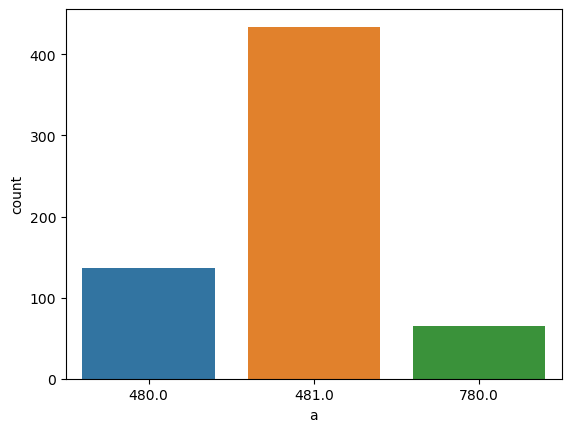

In [77]:
import seaborn as sns
sns.countplot(data_client_index['b'])
sns.countplot(data_client_index['a'])

In [192]:
# Calculer la distance entre chaque paire de points
from geopy import distance
taille_m = len(data_client_index)
distance_matrix = np.zeros((taille_m, taille_m))
for i, row_i in data_client_index.iterrows():
    for j, row_j in data_client_index.iterrows():
        if i != j:
            coord_i = (row_i['CUSTOMER_LATITUDE'], row_i['CUSTOMER_LONGITUDE'])
            coord_j = (row_j['CUSTOMER_LATITUDE'], row_j['CUSTOMER_LONGITUDE'])
            dist = distance.distance(coord_i, coord_j).km
            distance_matrix[i, j] = dist

In [288]:
CUSTOMER_DELIVERY_SERVICE_TIME = data_client_index['d'].values
TOTAL_WEIGHT_KG = data_client_index['TOTAL_WEIGHT_KG'].values
CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT = data_depot['TIME_DISTANCE_MIN'].values
CUSTOMER_DELIVERY_SERVICE_DISTANCE_FROM_DEPOT = data_depot['DISTANCE_KM'].values


In [286]:
def choix_client_suivant(client_potentiel,client_courant,methode):
        
    if methode==0:
            client_suivant = random.choice(client_potentiel)
     
    if methode==1:
            client_potentiel_distance = [distance_matrix[client_courant,client] for client in client_potentiel]
            client_suivant = client_potentiel[client_potentiel_distance.index(min(client_potentiel_distance))]

    return(client_suivant)

In [1002]:
def get_route_by_car(client_disponible,Q,V_moy,time_window):
    solution = []
    t = 480
    total_weight = 0
    i=0

    client_courant = 0
    client_potentiel = client_disponible

    # chosir le client le plus proche de depot
 
    client_suivant = random.choice(client_potentiel)

    
    t = t +  CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT[client_suivant] + CUSTOMER_DELIVERY_SERVICE_TIME[client_suivant]
    total_weight = total_weight+TOTAL_WEIGHT_KG[client_suivant]
    if total_weight<Q and t<time_window:
        solution.append(client_suivant)
    
     
     
    client_disponible.remove(client_suivant)

    client_courant = client_suivant
    client_potentiel = [client for client in client_disponible if  t+distance_matrix[client_courant,client]/V_moy < time_window and total_weight+TOTAL_WEIGHT_KG[client]<Q]
    i=1
    
    while len(client_potentiel)>0:
        
        client_suivant = random.choice(client_potentiel)
         
        solution.append(client_suivant)
        client_disponible.remove(client_suivant)
        

        t = t + distance_matrix[client_courant,client_suivant]/V_moy + CUSTOMER_DELIVERY_SERVICE_TIME[client_suivant]
        total_weight = total_weight+TOTAL_WEIGHT_KG[client_suivant]
        client_courant = client_suivant
 
        client_potentiel = [client for client in client_disponible if  t+distance_matrix[client_courant,client]/V_moy < time_window and total_weight+TOTAL_WEIGHT_KG[client]<Q]
        i+=1
    return(solution)
 

In [1003]:
def get_route_version0(Q,V_moy,time_window):
    client_disponible = [i for i in range(len(data_client_index))]
    Global_route = []
    k=0
    while len(client_disponible)>0:
        route_by_car = get_route_by_car(client_disponible,Q,V_moy,time_window)
        Global_route.append(route_by_car)
        client_disponible = [client for client in  client_disponible if client not in route_by_car]
    
    print('nombre des voitures utilisées ',len(Global_route))
    return(Global_route)

In [1004]:
Q = 5000
V_moy=60
time_window = 950
global_route = get_route_version0(Q,V_moy,time_window)
cout(global_route)

nombre des voitures utilisées  20


28965.483115776093

In [581]:
import random

# Définir les couleurs que vous voulez utiliser pour les voitures
couleurs_voitures = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF']

# Créer une carte centrée sur les coordonnées moyennes
carte = folium.Map(location=[latitude, longitude], zoom_start=10)

# Ajouter des marqueurs et des segments pour chaque client et chaque voiture
for i, clients in enumerate(global_route[:2]):
    # Générer une couleur aléatoire pour chaque voiture
    couleur = random.choice(couleurs_voitures)

    # Ajouter un marqueur pour chaque client
    for j, client in enumerate(clients):
        client_data = data_client_index.iloc[client]
        folium.Marker(location=[client_data['CUSTOMER_LATITUDE'], client_data['CUSTOMER_LONGITUDE']],
                      popup=str(client),
                      icon=folium.Icon(color=couleur)).add_to(carte)

        # Si ce n'est pas le dernier client visité par la voiture, ajouter un segment reliant ce client au client suivant
        if j < len(clients) - 1:
            client_suivant = clients[j + 1]
            client_suivant_data = data_client_index.iloc[client_suivant]
            folium.PolyLine(locations=[[client_data['CUSTOMER_LATITUDE'], client_data['CUSTOMER_LONGITUDE']],
                                       [client_suivant_data['CUSTOMER_LATITUDE'], client_suivant_data['CUSTOMER_LONGITUDE']]],
                            color=couleur).add_to(carte)


# Enregistrer la carte dans un fichier HTML
carte.save('carte_clients.html')



C:\Users\hicha\AppData\Local\Temp\ipykernel_120\1776759628.py:19: UserWarning: color argument of Icon should be one of: {'pink', 'orange', 'purple', 'lightred', 'red', 'black', 'cadetblue', 'lightblue', 'darkgreen', 'white', 'green', 'lightgreen', 'blue', 'gray', 'darkblue', 'lightgray', 'darkred', 'darkpurple', 'beige'}.
  icon=folium.Icon(color=couleur)).add_to(carte)


In [582]:
def cout(global_route):
    cout = 0
    for route in global_route:
       
        cout_depot_depart = CUSTOMER_DELIVERY_SERVICE_DISTANCE_FROM_DEPOT[route[0]]
        cout_depot_retour = CUSTOMER_DELIVERY_SERVICE_DISTANCE_FROM_DEPOT[route[-1]]
        cout = cout+sum([distance_matrix[route[i],route[i+1]] for i in range(len(route)-1)])+cout_depot_retour+cout_depot_depart

    return(cout+len(global_route))

In [701]:
 def get_route_version1(list_client,time_window,Q):
    Global_route = []
    client_numbre = len(list_client)
    client_visited = 0

    while  client_visited<client_numbre:

        client_disponible = list_client[client_visited:]
        route_by_car = []
        t = 480+CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT[client_disponible[0]]+CUSTOMER_DELIVERY_SERVICE_TIME[client_disponible[0]]
        weight = TOTAL_WEIGHT_KG[client_disponible[0]]
         
         
        i=0
        while t<time_window and weight<Q:

            route_by_car.append(client_disponible[i])
            i+=1
            if i>=len(client_disponible):
                break
            t = t+distance_matrix[client_disponible[i-1],client_disponible[i]]/V_moy + CUSTOMER_DELIVERY_SERVICE_TIME[client_disponible[i]]
            weight +=TOTAL_WEIGHT_KG[client_disponible[i]]
 
        client_visited+=i
        Global_route.append(route_by_car)
        
         

    return(Global_route)
            

In [620]:
matrice_temps_Cij= np.zeros((len(data_client_index)+1,len(data_client_index)+1))
for i in range(len(data_client_index)+1):
    for j in range(len(data_client_index)+1):
        if j==i:
            matrice_temps_Cij[i,j]=0
        elif i==0 or j ==0:
            matrice_temps_Cij[i,j] = CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT[max(i,j)-1]+CUSTOMER_DELIVERY_SERVICE_TIME[max(i,j)-1]
        else:
            matrice_temps_Cij[i,j] = distance_matrix[i-1,j-1]/V_moy + CUSTOMER_DELIVERY_SERVICE_TIME[j-1]

In [1015]:
import pickle

with open('matrice_temps_Cij.pickle', 'wb') as handle:
    pickle.dump(matrice_temps_Cij, handle, protocol=pickle.HIGHEST_PROTOCOL)



array([[  0.        , 138.73      ,  71.972     , ...,  55.004     ,
         34.628     , 134.272     ],
       [138.73      ,   0.        ,  22.05474381, ...,   9.31370517,
          9.50118257,  11.01094544],
       [ 71.972     ,   8.53474381,   0.        , ...,   9.42058138,
          9.97203899,  10.53258665],
       ...,
       [ 55.004     ,   8.49370517,  22.12058138, ...,   0.        ,
          9.79099484,  10.905945  ],
       [ 34.628     ,   8.20118257,  22.19203899, ...,   9.31099484,
          0.        ,  11.13713799],
       [134.272     ,   9.22094544,  22.26258665, ...,   9.935945  ,
         10.64713799,   0.        ]])

In [759]:
def get_route_version2(list_client,time_window,Q):
    arret = [0]
    i=0
    while i<len(list_client):
        weight = TOTAL_WEIGHT_KG[list_client[i]]
        time = 480+matrice_temps_Cij[0,list_client[i]+1]

        while time<time_window and weight<Q: 
            i+=1
            if i > len(list_client)-1:
                break
            time+=matrice_temps_Cij[list_client[i-1]+1,list_client[i]+1]
            weight+= TOTAL_WEIGHT_KG[list_client[i]]
             
        arret.append(i)
      
    
    Global_route =[list_client[arret[k]:arret[k+1]] for k in range(len(arret)-1)]
    return(Global_route)